In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
# create engine to hawaii.sqlite
#engine = create_engine("sqlite:///Users/jessicamaranto/desktop/databootcamp/sqlalchemy-challenge/Resources/hawaii.sqlite")

In [13]:
# Ensure this is the correct path
db_path = '/Users/jessicamaranto/desktop/databootcamp/sqlalchemy-challenge/Resources/hawaii.sqlite'
engine = create_engine(f'sqlite:///{db_path}')

In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)



In [15]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement  
Station = Base.classes.station  

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

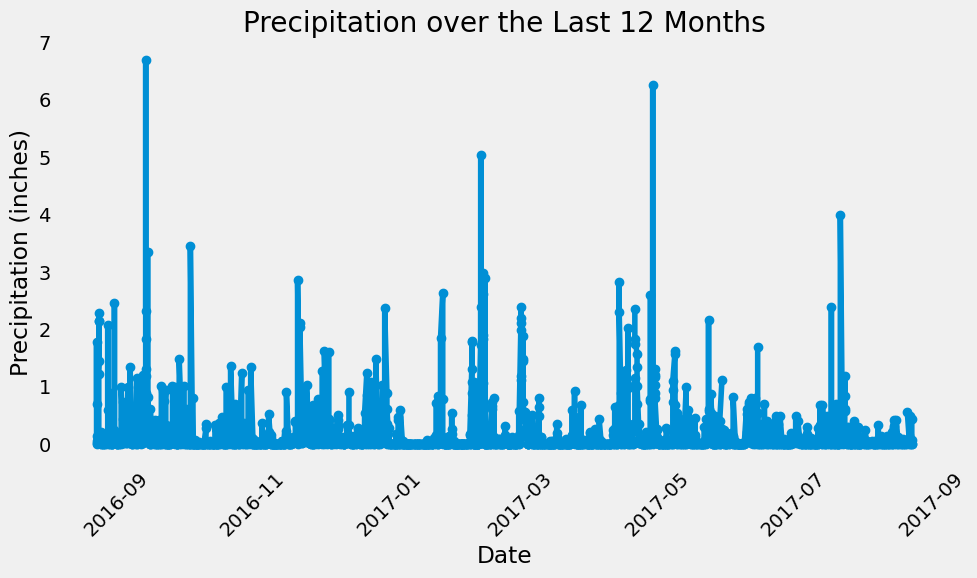

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date_point = recent_date[0]
# Calculate the date one year from the last date in the dataset.
year_ago_date = pd.to_datetime(recent_date_point) - pd.DateOffset(years=1)

# Convert year_ago_date to string in the format YYYY-MM-DD
year_ago_date_str = year_ago_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_date_str).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])
df_sorted = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))  
plt.plot(df_sorted['Date'], df_sorted['Precipitation'], marker='o', linestyle='-')
plt.title('Precipitation over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)

# Show grid
plt.grid()

# Display the plot
plt.tight_layout()  
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df_sorted['Precipitation'].describe()
summary_statistics

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

In [35]:
df.describe()

,Date,Precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [39]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Station.station,func.count(Measurement.station).label('count')
).join(Measurement, Station.station == Measurement.station)\
 .group_by(Station.station)\
 .order_by(func.count(Measurement.station).desc())\
 .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temps = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == 'USC00519281').all()
station_temps

[(54.0, 85.0, 71.66378066378067)]

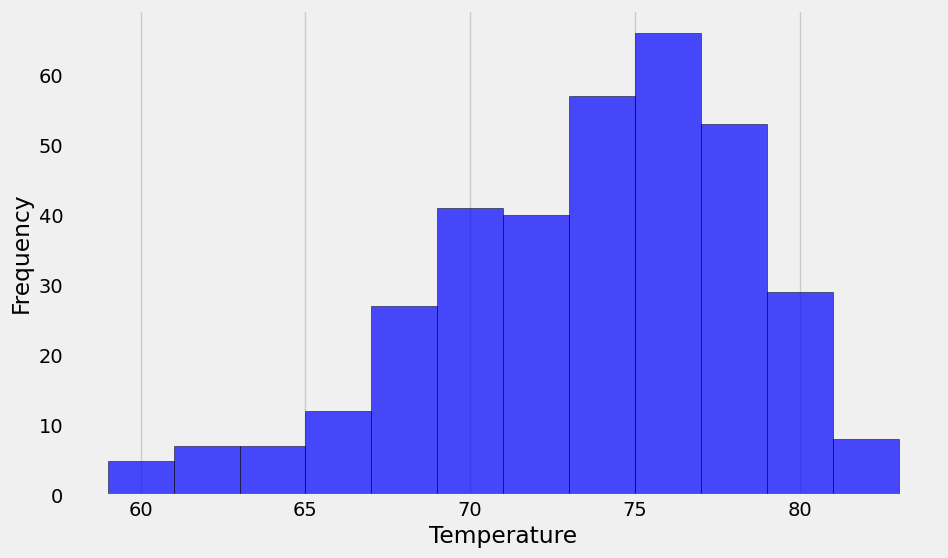

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Get the most recent date from the Measurement table
recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = pd.to_datetime(recent_date_row[0])

# Calculate the date one year ago
year_ago_date = recent_date - pd.DateOffset(years=1)
year_ago_date_str = year_ago_date.strftime('%Y-%m-%d')

# Query the last 12 months of temperature observations for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago_date_str).\
    order_by(Measurement.date).all()

# Convert the query results to a DataFrame
df_temperature = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram 
plt.figure(figsize=(10, 6))
plt.hist(df_temperature['Temperature'], bins=12, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Display the plot
plt.show()


# Close Session

In [48]:
# Close Session
session.close()